In [3]:
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
DIR_PATH = os.path.dirname(os.path.realpath(os.path.abspath('')))

import sys
sys.path.append(DIR_PATH)

# sys.path.append makes sure that the following imports work
from IVIMNET.simulations import sim_signal
from IVIMNET.utils.checkarg import checkarg
from IVIMNET.inference import infer_leastsquares_IVIM
from IVIMNET.inference import infer_supervised_IVIM
from IVIMNET.utils.hyperparams import hyperparams

%load_ext autoreload
%autoreload 2

VERBOSE_FLAG = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
key = 'sim'

if key == 'clinic':
    arg = hyperparams('clinic')
    mypath_IVIMNET = Path(f'{DIR_PATH}/saved/models/IVIMNET_July3rd_clinic/')
    mypath_IVIMSUPER = Path(f'{DIR_PATH}/saved/models/IVIMSUPER_clinic_models_1/') 
    mypath_IVIMCOMB = Path(f'{DIR_PATH}/saved/models/IVIMComb_clinic_models_2/') 
elif key == 'sim':
    arg = hyperparams('sim', verbose=VERBOSE_FLAG)
    mypath_IVIMNET = Path(f'{DIR_PATH}/saved/models/IVIMNET_saved_models/') 
    mypath_IVIMSUPER = Path(f'{DIR_PATH}/saved/models/IVIMSUPER_saved_models/May28th/') 
    mypath_IVIMCOMB = Path(f'{DIR_PATH}/saved/models/IVIMCOMB_saved_models_exp3/') 
else:
    mypath_IVIMNET, mypath_IVIMSUPER, mypath_IVIMCOMB = " ", " ", " "

arg = checkarg(arg)
bvalues = arg.sim.bvalues
n_samples  = 5000
SNR_vector = [100, 75, 50, 33, 25, 20, 15, 12, 10, 8]

## Least squares

In [5]:
Dp_SNR_lsq, Dt_SNR_lsq, Fp_SNR_lsq, S0_SNR_lsq = [], [], [], []
Dp_SNR_NMSE_lsq, Dt_SNR_NMSE_lsq, Fp_SNR_NMSE_lsq, S0_SNR_NMSE_lsq = [], [], [], []

for i, SNR in enumerate(SNR_vector):
    # generate simulated signal
    IVIM_signal_noisy, D, f, Dp = sim_signal(SNR, bvalues, n_samples, 
                                             Dmin=arg.sim.range[0][0], Dmax=arg.sim.range[1][0], 
                                             fmin=arg.sim.range[0][1], fmax=arg.sim.range[1][1], 
                                             Dsmin=arg.sim.range[0][2], Dsmax=arg.sim.range[1][2], 
                                             rician=arg.sim.rician, state=0)

    # take the labels generated and put them together
    labels = np.stack((D, f, Dp), axis=1).squeeze()

    # inference with least squares
    Dp_e_lsq, Dt_e_lsq, Fp_e_lsq, S0_lsq_NRMSE = infer_leastsquares_IVIM(IVIM_signal_noisy, labels, bvalues, arg, verbose=VERBOSE_FLAG)
    Dp_SNR_lsq.append(Dp_e_lsq)
    Dp_SNR_NMSE_lsq.append(np.median(Dp_e_lsq))
    Dt_SNR_lsq.append(Dt_e_lsq)
    Dt_SNR_NMSE_lsq.append(np.median(Dt_e_lsq))
    Fp_SNR_lsq.append(Fp_e_lsq)
    Fp_SNR_NMSE_lsq.append(np.median(Fp_e_lsq))
    

## IVIMSUPER

In [6]:
models_paths_super = [f for f in listdir(mypath_IVIMSUPER) if isfile(join(mypath_IVIMSUPER, f))]
models_paths_super.reverse()

Dp_SNR, Dt_SNR, Fp_SNR, S0_SNR = [], [], [], []
Dp_SNR_NMSE_ivimsuper, Dt_SNR_NMSE_ivimsuper, Fp_SNR_NMSE_ivimsuper, S0_SNR_NMSE = [], [], [], []
 
for i, SNR in enumerate(SNR_vector):
    # generate simulated signal
    IVIM_signal_noisy, D, f, Dp = sim_signal(SNR, bvalues, n_samples, Dmin=arg.sim.range[0][0],
                                             Dmax=arg.sim.range[1][0], fmin=arg.sim.range[0][1],
                                             fmax=arg.sim.range[1][1], Dsmin=arg.sim.range[0][2],
                                             Dsmax=arg.sim.range[1][2], rician=arg.sim.rician, state=0)

    # take the labels generated and put them together
    labels = np.stack((D, f, Dp), axis=1).squeeze()

    ivimsuper_path = join(mypath_IVIMSUPER, models_paths_super[i])
    
    Dt_e_super, Fp_e_super, Dp_e_super, S0_e_super = infer_supervised_IVIM(IVIM_signal_noisy, labels,
                                                                     bvalues, ivimsuper_path, arg,
                                                                     verbose=VERBOSE_FLAG)
  
    Dp_SNR.append(Dp_e_super)
    Dp_SNR_NMSE_ivimsuper.append(np.median(Dp_e_super))
    Dt_SNR.append(Dt_e_super)
    Dt_SNR_NMSE_ivimsuper.append(np.median(Dt_e_super))
    Fp_SNR.append(Fp_e_super)
    Fp_SNR_NMSE_ivimsuper.append(np.median(Fp_e_super))
    S0_SNR.append(S0_e_super)
    S0_SNR_NMSE.append(np.median(S0_e_super))


## IVIMNET

In [7]:
models_paths_ivimnet = [f for f in listdir(mypath_IVIMNET) if isfile(join(mypath_IVIMNET, f))]
models_paths_ivimnet.reverse()

Dp_SNR_ivimnet, Dt_SNR_ivimnet, Fp_SNR_ivimnet, S0_SNR_ivimnet = [], [], [], []
Dp_SNR_NMSE_ivimnet, Dt_SNR_NMSE_ivimnet, Fp_SNR_NMSE_ivimnet, S0_SNR_NMSE_ivimnet = [], [], [], []

for i, SNR in enumerate(SNR_vector):
    # generate simulated signal
    IVIM_signal_noisy, D, f, Dp = sim_signal(SNR, bvalues, n_samples, Dmin=arg.sim.range[0][0],
                                             Dmax=arg.sim.range[1][0], fmin=arg.sim.range[0][1],
                                             fmax=arg.sim.range[1][1], Dsmin=arg.sim.range[0][2],
                                             Dsmax=arg.sim.range[1][2], rician=arg.sim.rician, state=0)

    # take the labels generated and put them together
    labels = np.stack((D, f, Dp), axis=1).squeeze()

    #### IVIMNET
    ivimnet_path = join(mypath_IVIMNET, models_paths_ivimnet[i])
    
    Dt_e_ivimnet, Fp_e_ivimnet, Dp_e_ivimnet, S0_e_ivimnet = infer_supervised_IVIM(IVIM_signal_noisy, labels,
                                                                        bvalues, ivimnet_path, arg, verbose=VERBOSE_FLAG)
  
    Dp_SNR_ivimnet.append(Dp_e_ivimnet)
    Dp_SNR_NMSE_ivimnet.append(np.median(Dp_e_ivimnet))
    Dt_SNR_ivimnet.append(Dt_e_ivimnet)
    Dt_SNR_NMSE_ivimnet.append(np.median(Dt_e_ivimnet))
    Fp_SNR_ivimnet.append(Fp_e_ivimnet)
    Fp_SNR_NMSE_ivimnet.append(np.median(Fp_e_ivimnet))
    S0_SNR_ivimnet.append(S0_e_ivimnet)
    S0_SNR_NMSE_ivimnet.append(np.median(S0_e_ivimnet))


## IVIMCOMB

In [8]:
models_paths_ivimcomb = [f for f in listdir(mypath_IVIMCOMB) if isfile(join(mypath_IVIMCOMB, f))]
models_paths_ivimcomb.reverse()
Dp_SNR_ivimcomb, Dt_SNR_ivimcomb, Fp_SNR_ivimcomb, S0_SNR_ivimcomb = [], [], [], []
Dp_SNR_NMSE_ivimcomb, Dt_SNR_NMSE_ivimcomb, Fp_SNR_NMSE_ivimcomb, S0_SNR_NMSE_ivimcomb = [], [], [], []

for i, SNR in enumerate(SNR_vector):
    # generate simulated signal
    IVIM_signal_noisy, D, f, Dp = sim_signal(SNR, bvalues, n_samples, Dmin=arg.sim.range[0][0],
                                             Dmax=arg.sim.range[1][0], fmin=arg.sim.range[0][1],
                                             fmax=arg.sim.range[1][1], Dsmin=arg.sim.range[0][2],
                                             Dsmax=arg.sim.range[1][2], rician=arg.sim.rician, state=0)

    # take the labels generated and put them together
    labels = np.stack((D, f, Dp), axis=1).squeeze()

    #### IVIMCOMB
    ivimcomb_path = join(mypath_IVIMCOMB, models_paths_ivimcomb[i])
    Dt_e_ivimcomb, Fp_e_ivimcomb, Dp_e_ivimcomb, S0_e_ivimcomb = infer_supervised_IVIM(IVIM_signal_noisy, labels,
                                                                        bvalues, ivimcomb_path, arg, verbose=VERBOSE_FLAG)
  
    Dp_SNR_ivimcomb.append(Dp_e_ivimcomb)
    Dp_SNR_NMSE_ivimcomb.append(np.median(Dp_e_ivimcomb))
    Dt_SNR_ivimcomb.append(Dt_e_ivimcomb)
    Dt_SNR_NMSE_ivimcomb.append(np.median(Dt_e_ivimcomb))
    Fp_SNR_ivimcomb.append(Fp_e_ivimcomb)
    Fp_SNR_NMSE_ivimcomb.append(np.median(Fp_e_ivimcomb))
    S0_SNR_ivimcomb.append(S0_e_ivimcomb)
    S0_SNR_NMSE_ivimcomb.append(np.median(S0_e_ivimcomb))


## Plot mean values

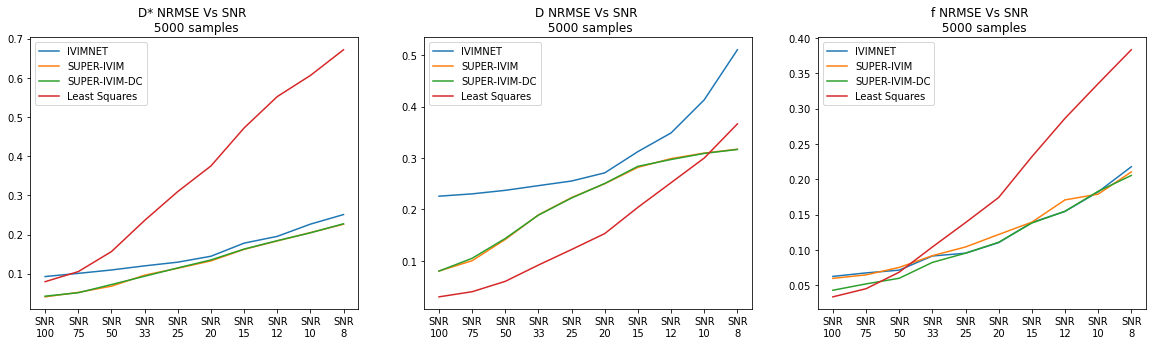

In [9]:
fig_NRMSE_Dp, ax_NRMSE = plt.subplots(ncols=3, figsize=(20,5))

ax_NRMSE[0].plot(Dp_SNR_NMSE_ivimnet)
ax_NRMSE[0].plot(Dp_SNR_NMSE_ivimsuper)
ax_NRMSE[0].plot(Dp_SNR_NMSE_ivimcomb)
ax_NRMSE[0].plot(Dp_SNR_NMSE_lsq)
ax_NRMSE[0].set_title(f'D* NRMSE Vs SNR \n {n_samples} samples')

ax_NRMSE[1].plot(Dt_SNR_NMSE_ivimnet)
ax_NRMSE[1].plot(Dt_SNR_NMSE_ivimsuper)
ax_NRMSE[1].plot(Dt_SNR_NMSE_ivimcomb)
ax_NRMSE[1].plot(Dt_SNR_NMSE_lsq)
ax_NRMSE[1].set_title(f'D NRMSE Vs SNR \n {n_samples} samples')

ax_NRMSE[2].plot(Fp_SNR_NMSE_ivimnet)
ax_NRMSE[2].plot(Fp_SNR_NMSE_ivimsuper)
ax_NRMSE[2].plot(Fp_SNR_NMSE_ivimcomb)
ax_NRMSE[2].plot(Fp_SNR_NMSE_lsq)
ax_NRMSE[2].set_title(f'f NRMSE Vs SNR \n {n_samples} samples')

for ax in ax_NRMSE:
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                  ["SNR\n100", "SNR\n75", "SNR\n50", "SNR\n33", "SNR\n25", "SNR\n20", "SNR\n15", "SNR\n12", "SNR\n10", "SNR\n8"])
    ax.legend(["IVIMNET", "SUPER-IVIM", "SUPER-IVIM-DC", "Least Squares"])
